# 얼굴인식

#### Face detection, 얼마나 작고 빨라질 수 있을까?

지난 시간까지 카메라 스티커앱을 만들면서 이미지 속의 얼굴을 빠르고 정확하게 인식하는 방법에 대해 고민해왔다. 첫번째로 고려해본 방법은 Dlib 라이브러리를 이용해사 Face Landmark를 찾아내는 것이었다. 하지만 이것만으로 충분하진 않았다.

Dlib 라이브러를 이용해 Face Landmark 문제점은 
1. 얼굴을 잘 못찾는다.
2. 동영상을 처리하기엔 너무 느리다.
3. 얼굴각도, 방향, 크기 등의 변화에 취약하다.


#### 왜 작아지고 빨라지는 게 중요할까?

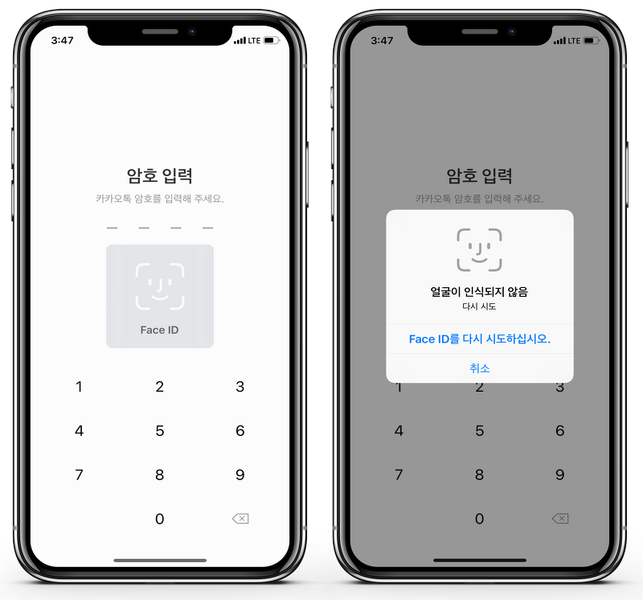

우선 비대면 인증수단으로 얼굴인식이 보편적으로 사용되기 시작했다는 점을 들을 수 있다. 얼굴 인식을 위해 딥러닝 서버 구동이 필요한 모델을 활용할 수 있을까?

서버로 이미지를 보낸 후 처리하는 방식은 네트워크 비용 + 서버 비용 + 인터넷 속도의 영향을 고려하지 않을 수 없다. 따라서 네트워크 상황과 무관하게 항상 동작해야 하는 핸드폰 인증 수단으로는 적합하지 않다. 그렇다면 edge device(= 핸드폰)를 바로 이용하려면 어떻게 해야 할까?

핸드폰에 모델을 올리려면 weight가 작은 모델이 관리에 유리하다. 하지만 일반적으로 작은 모델은 성능이 떨어지기 때문에 어떻게 보완할 수 있을 지 고민이 시작된다.

국내 IT 대기업들도 관련 연구를 활발히 진행하고 있다.

카카오 얼굴인식 관련 리서치 : https://tech.kakaoenterprise.com/63

네이버 얼굴검출 관련 오픈소스 : https://github.com/clovaai/EXTD_Pytorch

#### 아땋게 빠르게 만들 수 있을까 ?

Face detection에서 많은 시간이 드는 요소는 Sliding window이다. 그러므로 Sliding window를 버려야 빨라진다. 따라서 2-stage 방식의 detection은 좋은 선택이 아니다.

또 연산의 병렬화가 가능해야 한다. 컴퓨터의 GPU에서는 병렬화가 가능하지만 핸드폰에서도 병렬화가 가능할까?

크게는 안드로이드와 아이폰의 경우로 나누어 생각해볼 수 있다. 안드로이드에서는 MLKit, 아이폰에서는 CoreML이라는 라이브러리를 통해 병렬화를 할 수 있다. 하지만 제한이 많기 때문에 TFLite라는 도구를 이용하여 훈련된 모델을 이용하기도 한다.

Core ML : https://developer.apple.com/documentation/coreml

ios 11 machine learning for everyone : https://machinethink.net/blog/ios-11-machine-learning-for-everyone/

ML kit : https://developers.google.com/ml-kit

TFLite : https://www.tensorflow.org/lite?hl=ko

위 방법으로도 해결이 안 된다면 어렵더라도 다른 방법을 생각해봐야 한다. 우선 직접 병렬프로그래밍 라이브러리를 만들어 볼 수 있다. 하지만 그 난이도는 어마어마하다. 비교적 쉬운 방법으로는 병렬화 도구를 사용하는 방법이 있다.

SIMD-병렬-프로그래밍 : https://stonzeteam.github.io/SIMD-%EB%B3%91%EB%A0%AC-%ED%94%84%EB%A1%9C%EA%B7%B8%EB%9E%98%EB%B0%8D/

OpenCL : https://www.khronos.org/opencl/

Android: Open GL ES : https://developer.android.com/guide/topics/graphics/opengl?hl=ko

하지만 무엇보다도 적은 파라미터 수로도 정확한 성능을 가지는 모델을 설계하는 게 중요하다. 다음 스텝부터 알아보도록 하자.

### Single Stage Object Detection

2-Stage Detector은 정확도는 높지만 실행속도(FPS)가 느리다.

간단히 정리하자면 2-Stage Detector는 물체가 존재하는 bounding box를 먼저 찾은(localization) 후에 bounding box를 분류 (classification)하는 두가지 과정을 순차적으로 거쳤기 때문에, 속도가 느렸다.

하지만 이전 스텝에서 살펴본 것처럼, 얼굴 인식과 같이 딥러닝 모델이 가벼워야 하는 task는 1-Stage 기반을 사용하는 것이 유리하다. 1-Stage Detector는 localization과 classification을 동시에 수행한다.따라서 2단계를 거치는 2-Stage Detector보다는 속도가 빠르다. 하지만 정확도가 낮다는 단점이 있다.

아래의 그림에서 2-Stage Detector와 1-Stage Detector에 해당하는 모델이 어떤 것이 있는 지 볼 수 있다.

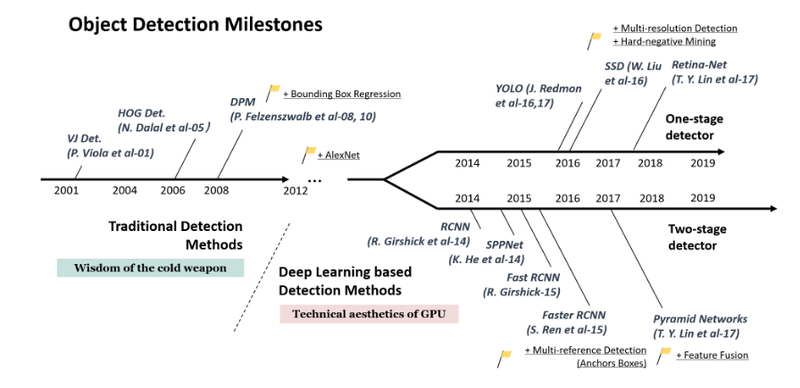

혹시 이전에 공부했던 Object Detection과 관련해서 복습이 필요하다면 아래 참고자료를 활용하자.

Fast Detection Models : https://lilianweng.github.io/posts/2018-12-27-object-recognition-part-4/

What do we learn from single shot object detectors, FPN & Focal loss? : https://jonathan-hui.medium.com/what-do-we-learn-from-single-shot-object-detectors-ssd-yolo-fpn-focal-loss-3888677c5f4d

윗글의 번역본 : https://murra.tistory.com/17

이후 스텝에서 우리는 1-stage(Single stage) Object detection 모델을 위주라 하여 Face detection에 적합한 딥러닝 모델들에 대해 탐색해 보겠다. YOLO, SSD, RetinaNet 등 이 분야의 모델들의 발전사는 딥러닝 분야에서도 매우 흥미진진한 이력을 가지고 있으니, 함께 살펴보자.

### YOLO (1) YOLO v1의 등장

#### YOLO : You Only Look Once

YOLO라는 모델의 네이밍 센스는 과연 어디에서 왔을까? YOLO라는 유명한 모델을 언급하려면 절대 빼놓을 수 없는 한 사람이 있다. 바로 Joseph Redmon, 즉 YOLO 논문의 1저자이자 C로 구현된 오픈소스 뉴럴 네트워크 Darknet의 제작자이다.

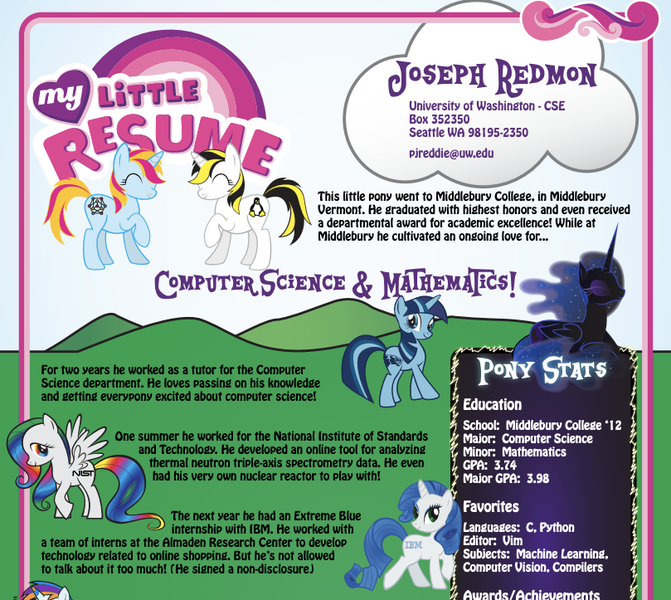

광고 전단지같이 생긴 위 그림은... 바로 Joseph Redmon의 이력서(CV)입니다. 장난같겠지만... 네, 실화입니다.😆

#### YOLO v1, big wave의 시작

YOLO의 출현은 당시 전 세계 computer vision 학계와 업계에 충격적일 정도의 기술 진보를 보여주었다. 우선 "You Only Look Once : Unified, Real-Time Object Detection'라는 제목의 영상을 먼저 소개하겠다.

https://www.youtube.com/watch?time_continue=607&v=NM6lrxy0bxs&feature=emb_title

CVPR 2016

무려 2016년도에 CVPR oral session에서 실시간 데모를 했다. 지금은 자연스로워 보일 수도 있지만, 당시 기술 수준을 생각해보면 이것은 충격과 공포 그 자체였다.

'스타트업' 이라는 드라마에서 이 장면이 떠오른다. YOLO vs. Faster R-CNN? 😆



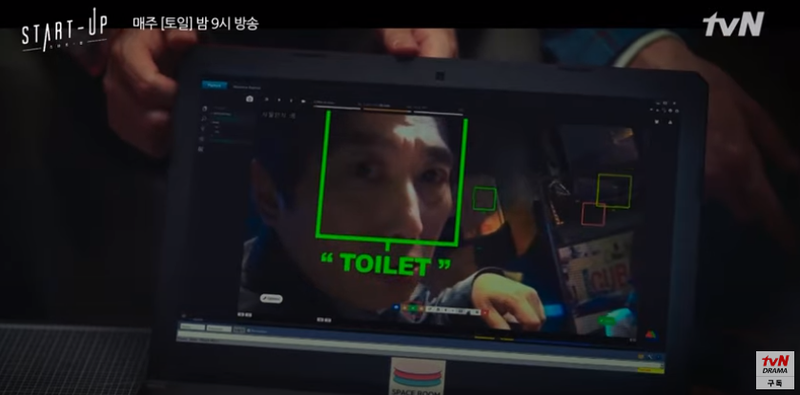

실제로 YOLO를 실행했을 때의 결과는 아래의 그림과 같다. 사람을 비행기로 인식한 것 외에는 꽤 잘 detection했다.

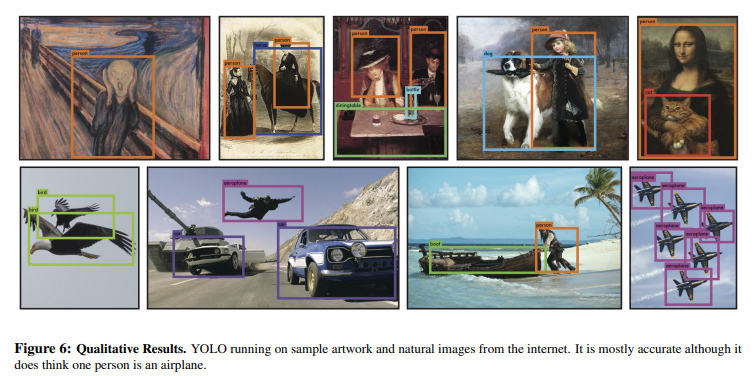

"You Only Look Once: Unified, Real-Time Object Detection"는 CVF 채널에서 유튜브 조회 수 1위 동영상이다. 참고로 2위는 2 stage detector 기반인 Mask-R-NN이다. Detection이 사람들이 얼마나 관심이 많은 지 알 수 있는 대목이다.

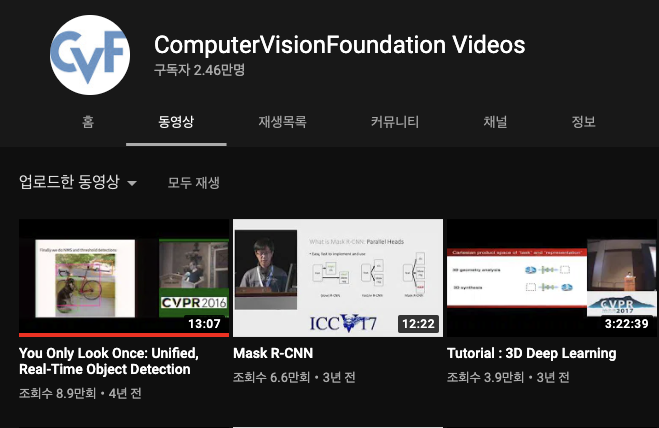

### YOLO (2) YOLO v1의 원리

이제부터 YOLO v1의 원리에 대해 알아보자. YOLO를 설명한 논문은  You Only Look Once:Unified, Real-Time Object Detection이다.

https://arxiv.org/pdf/1506.02640.pdf

#### YOLO의 특징

YOLO의 특징은 'You Only Look Once: Unified, Real-Time Object Detection'라는 논문 제목에 잘 드러나 있다.

1. You Only Look Once

전체 이미지를 보는 횟수가 1회라는 것을 의미한다. YOLO는 클래스에 대한 정보와 주변 정보까지 한 번에 학습하고 처리한다. 따라서 배경 오류가 적고 일반화 성능이 좋다.

2. Unified

Localization과 Classification을 동시에 수행한다. YOLO는 이미지를 신경망에 넣어주기만 하면 바로 detection이 가능하다.

3. Real-Time

기본적인 YOLO 모델로서 45FPS(초당 프레임수), 빠른 버전은 150FPS까지 성능을 보인다. (참고로 Fast R-CNN은 0.5FPS, DPM은 30FPS의 성능을 가지고 있다.) 따라서 스트리밍 비디오에서도 실시간으로 객체를 detection할 수 있다.

그 외에도 Object detection을 회귀 문제로 관점을 전환했고, 여러 도메인에서 object detection이 가능하다는 특징이 있다.

#### RCNN과 YOLO

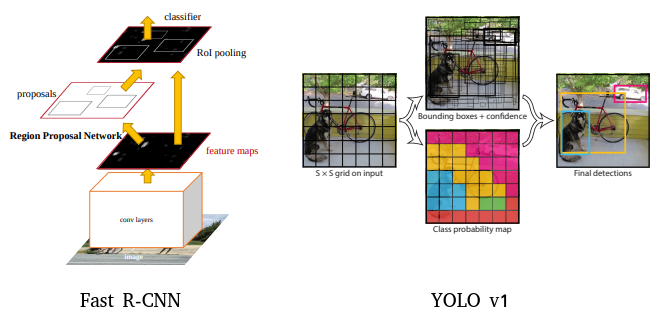

대표적인 2-stage detector인 RCNN과 1-stage detector인 YOLO 모델은 아래와 같이 기본 가정이 차이난다.

1. RCNN 계열의 가정 :
"객체가 존재할 것 같은 곳을 backbone network로 표현할 수 있다." → Region Proposal Network(RPN)
2. YOLO v1의 가정 :
"이미지 내의 작은 영역을 나누면 그곳에 객체가 있을 수 있다." → grid 내에 객체가 존재한다.

따라서 YOLO v1에서 gird는 고정되고, 각 grid 안에 객체가 있을 확률이 중요하게 된다.

#### YOLO의 grid cell

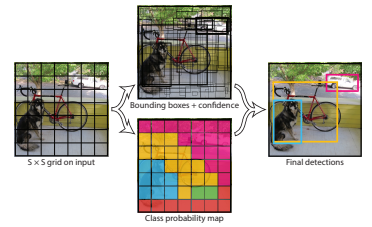

YOLO는 이미지를 S x S gird로 나누고, box regression 단계와 각 클래스마다 probability map을 구하는 단계가 동시에 병렬적으로 수행된다.

논문에서는 입력 이미지를 7 x 7 gird로 나누고, 각 gird cell마다 예측하는 bound box(bbox)를 2개, 총 클래스의 수는 20으로 정했다.

각 gird cell은 bounding box(bbox)와 C개의 class 확률을 예측한다.

각 bounding box(bbox, B)는 x,y,w,h cofidence score를 예측한다. x,y는 bbox의 중심 좌표이고 w와 h는 너비와 높이이다. 주의할 점은 w와 h는 입력 이미지를 bbox의 너비와 높이를 나눠서 normalize한 값으로, 0과 1 사이의 값을 가진다는 것이다.

confidence score는 box가 객체를 포함하고 있는 지를 모델이 얼마나 자신 있는지, 그리고 박스가 예측하는 것이 얼마나 정확한지를 보여준다. 이를 식으로 나타내면 아래와 같다.

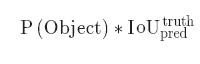

만약 gird cell이 객체를 포함하지 않으면 P(Object)이 0이므로 confidence score는 0이다. gird cell이 객체를 정확히 포함하고 있다면 P(Object)는 1이므로 결국 IoU만 남는다. 따라서 confidence score가 예측된 box와 ground truth box 사이의 IoU와 같도록 하는 것이 좋다.

C개의 조건부 클래스 확률 P(Classi|Object)은 grid cell이 사물을 포함할 때 bbox 안의 객체가 i번째 클래스에 속할 확률이다. bounding box의 개수와 상관 없이 각 grid cell의 확률만 예측한다.

위의 내용을 정리하면 하나의 grid cell에 대해 아래와 같은 tensor가 나온다.

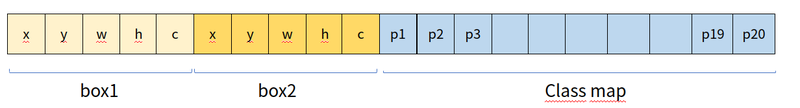

##### Question

Q3. 1개의 7x7 grid 당 2개의 bounidng box(BBox) 와 20개 클래스를 예측하는 YOLO 를 만들고 싶은 경우, output tensor의 크기와 이를 flatten했을 때의 크기는 무엇인가요?

output tensor의 크기는 7 x 7 x (5 x 2 + 20)이며, 이를 flatten하면 1470이다.

위의 이미지에서 보면 자전거를 포함하는 gird가 많다. 이런 경우는 해당 grid의 bbox가 모두 자전거라고 예측할까? 학습이 잘된 경우는 해당 grid들이 모두 비슷한 크기로 자전거의 bbox를 잡는다. 여기서 동일한 객체를 잡는 bbox가 많아진다는 문제가 생긴다.

이떄는 NMS(Non-Maximum Suppression)와 같은 기법을 이용한다. 비-최대 억제라고도 불리는 NMS 기법은 object detector가 예측한 여러 개의 bounding box 중 정확한 bounding box만을 선택하는 기법이다.

NMS의 알고리즘은 아래와 같다.

1. 하나의 클래스에 대한 높은 confidence score 순서대로 bbox를 정렬한다. confidence score가 특정 threshold를 넘지 않는 것은 제거한다.

2. 가장 높은 Confidence Score의 bbox와 겹치는 다른 bbox를 비교하여 IoU가 threshold보다 높으면 겹치는 bbox를 목록에서 제거한다. 두 bbox의 IoU가 높다는 것은 같은 객체를 detect하고 있다는 의미이기 때문이다.

3. 1과 2의 과정을 반복해 마지막으로 남은 bbox를 반환한다.

4. 각 클래스에 대해 위의 과정을 반복한다.

NMS 알고리즘을 적용하면 아래와 그림과 같이 겹쳐 있는 bounding box 중 정확한 bounding box만 표시된다.

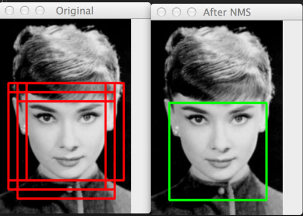

YOLO의 목표는 gird에 포함되는 개체를 잘 잡아내는 것이다. 즉 grid cell에 속하는 객체를 검출함 책임이 있는 거죠. 따라서 1개 grid에 귀촉된 bbox 정보 (x,y,w,h)의 학습 목표는 bbox의 ground truth와 최대한 동일하도록 학습되는 것이다. 학습 목표가 제대로 이루어졌는지를 확인하려면 객체 인식 모델의 성능 평가 도구인 IoU(Intersection over Union)를 사용하면 되겠다.

https://ballentain.tistory.com/12

#### YOLO의 네트워크 구조

YOLO의 네트워크 구조는 아래 그림과 같이 24개의 Conv 레이어와 2개의 Fully connected 레이어로 이루어져 있다.

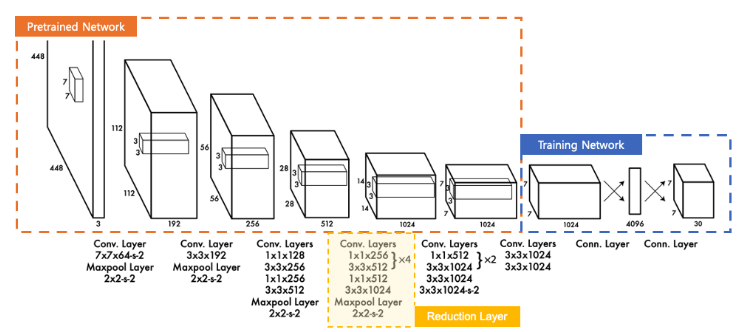

모델 구조의 앞부분(Pretrained)은 ImageNet의 1000개 클래스 데이터셋을 가지고 사전학습한 GoogLeNet 모델이다. 사전학습을 위해 20개의 Conv 레이어와 average pooling 레이어와 fully-connected 레이어를 사용하였다. 그러나 GoogLeNet의 Inception 모듈 대신 1x1 reduction 레이어를 사용하여 연산량을 감소시켰다.

detection을 위해 사전학습된 모델에 4개의 Conv 레이어와 2개의 FC레이어를 추가하였고, PASCAL VOC 데이터셋으로 fine-tuning하였다. fine-grained 이미지를 얻기 위해 원래의 224 x 224 이미지의 2배인 448 x 448의 이미지를 사용했다고 한다.

마지막 레이어는 Class 확률와 bbox 좌표를 학습하고 예측하여 S x S x (B*5 + C) 크기의 텐서로 예측값이 출력된다.

#### YOLO의 Inference 과정

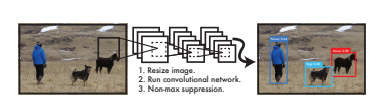

Inference를 할 때는 조건부 클래스 확률 P(Classi | Object)를 각 box의 confidence 예측값과 곱해 각 box의 클래스별 confidence score(class-specific confidence score)를 얻을 수 있다. 각 score는 box의 클래스의 확률과 예측된 box가 사물을 얼마나 잘 예측하는 지를 보여준다.

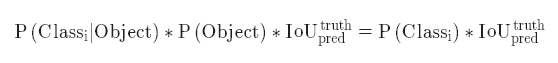

이 과정을 모든 bbox에서 시행하면 한 이미지에서 예측한 클래스별 confidence score의 개수는 7\*7*2 = 98개이다. 이 98개의 클래스별 confidence score에 대해 20개의 class를 기준으로 NMS를 하여 object에 대한 class와 bounding box location을 결정할 수 있다.

### YOLO (3) YOLO v1의 성능

#### YOLO v1의 loss 함수

YOLO의 loss는 bbox의 위치 예측과 관련된 localization loss와 클래스 예측과 관련된 classification loss가 있으며, 두 loss 모두 SSE(sum-squared error)를 기반으로 한다. 그런데 SSE는 이 두 loss를 동일하게 가중치를 준다. 이런 상황은 이상적이 아니다. 뿐만 아니라 이미지 내 대부분의 grid cell에 객체가 없을 경우가 일반적인데, 이런 경우에는 confidence score가 0에 가깝게 된다. 이는 모델의 불균형을 초래한다.

이런 문제를 해결하기 위해 bbox의 좌표에 대한 loss를 증가시키고, 객체가 없는 box의 confidence 예측값의 loss는 감소시켰다. 이를 위해 

캡처.PNG

라는 두개의 하이퍼파라미터를 사용했다.

뿐만 아니라 SSE는 큰 bbox와 작은 bbox의 loss를 모두 동일한 가중치로 계산한다. 그러나 작은 bbox가 큰 bbox보다 조그마한 위치 변화에도 더 민감하다. 이를 개선하기 위해 bbox의 너비와 높이에 square root를 취해주었다.

YOLO의 loss 함수는 아래와 같다.

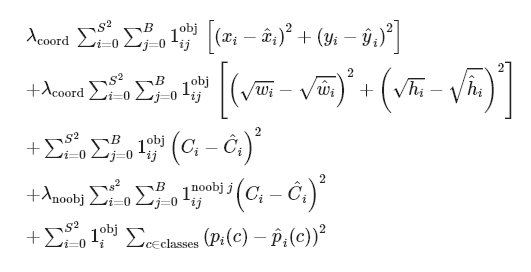

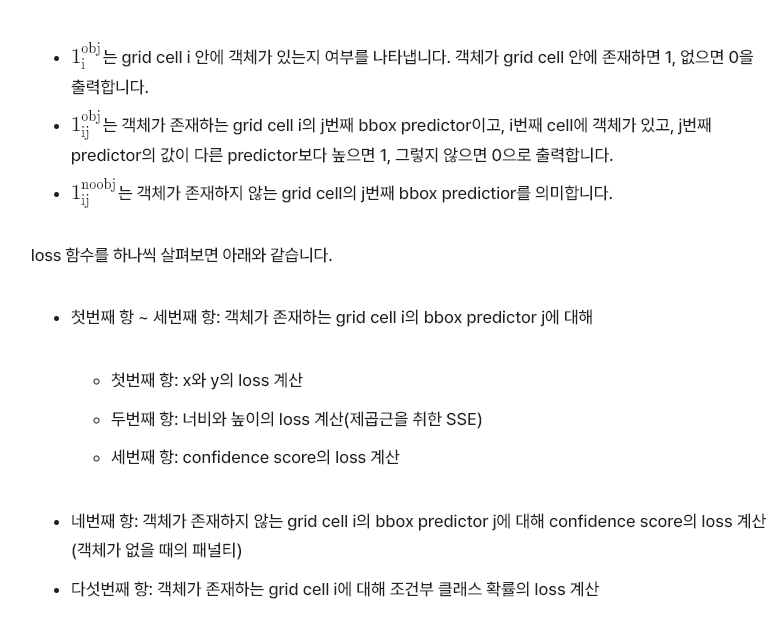

#### YOLO의 성능

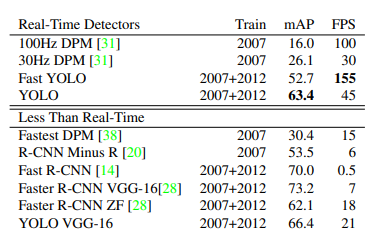

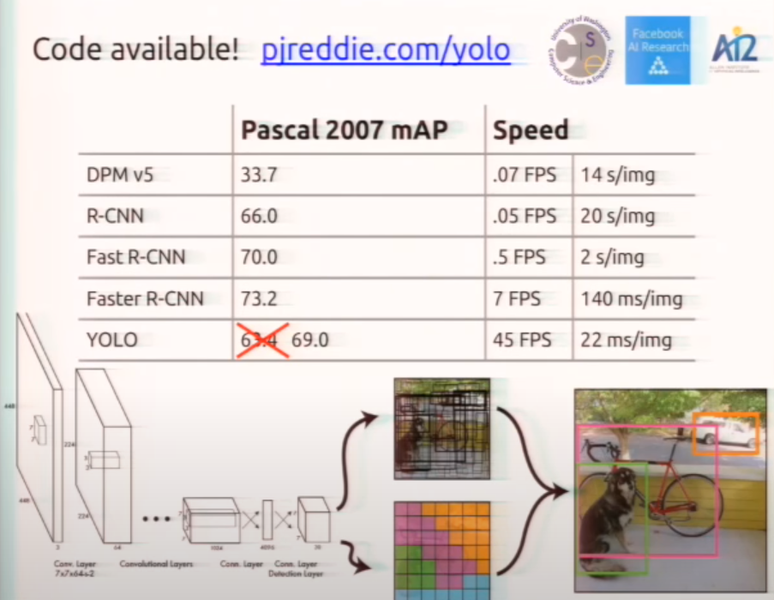

arXiv 논문 발표에서는 mAP가 63.4였지만 CVPR 2016 발표 때는 69.0으로 모델의 성능을 향상되어 발표되었다. 즉 YOLO v1은 Faster R-CNN과 성능에 큰 차이가 나지 않으면서 속도는 6배 이상인 혁신적인 연구였다.

#### YOLO v1 의 단점

획기적이었던 YOLO v1에도 단점은 있었다. 우선 각각 grid cell이 2개인 box와 하나의 클래스만 예측 가능하므로 가까이에 있는 여러 개의 객체를 예측하기 어려웠다. 특히 새떼와 같이 그룹으로 나타나는 작은 object에 대해 예측을 제대로 하지 못했다.

또한 bbox의 형태가 training data를 통해 학습되었기 때문에 bbox 분산이 너무 넓어 새로운 형태의 bbox 예측이 잘 안되기도 한다. 모델 구조상 backbone만 거친 feature map을 대상으로 bbox 정보를 예측하기 때문에 localization이 다소 부정확했다.

마지막으로 loss 함수가 작은 bbox와 큰 bbox의 loss를 같게 다루기 때문에 큰 box의 작은 loss 보다 작은 box의 작은 loss가 IoU에 더 큰 영향을 미쳤다. 그래서 2017년 YOLO v2이 나오게 된다.

### YOLO (4) YOLO v2

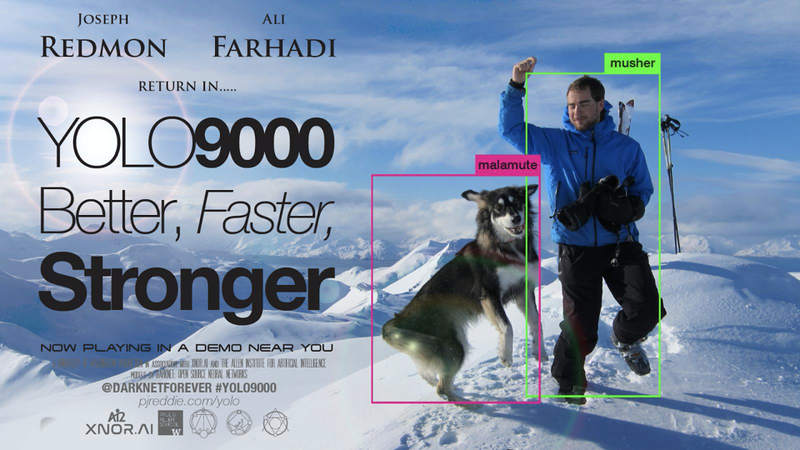

Object Detection에 혁신을 가져온 Redmon은 1년 뒤인 CVPR 2017에 YOLO를 v2로 발전시켜 가지고 왔다. 위의 이미지는 실제 발표 자료에 포함된 것이었다. 

Joseph Redmon의 발표자료에서 intro에서 YOLO 자체로 좋긴 좋았는데 정확도가 아쉬웠다고 언급했다.

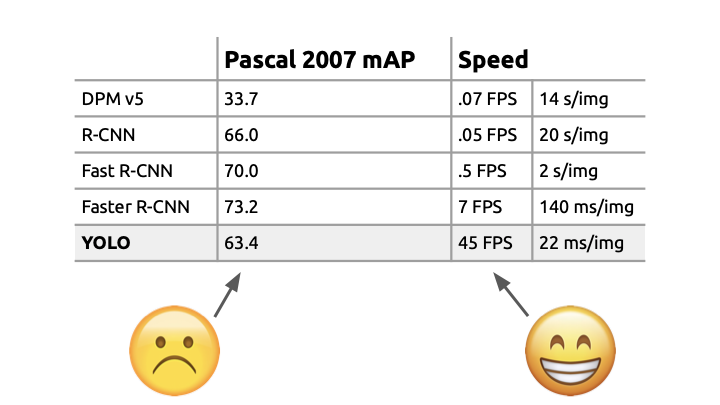

CVPR 2016에서의 데모 중에 Redmon이 잠깐 사라진 적이 있는데, YOLO가 뒷문을 화장실로 인식해버리는 사고였다. Redmon은 CVPR 2017에서 이때 장면을 캡쳐해서 가지고 나왔다. 즉 YOLO의 정확도가 낮다는 것을 보여주기 위한 예였다. 이전 스틉에서 언급한 드라마 '스타트업'에서도 사람의 얼굴을 화장실로 인식했던 것이 기억난다.

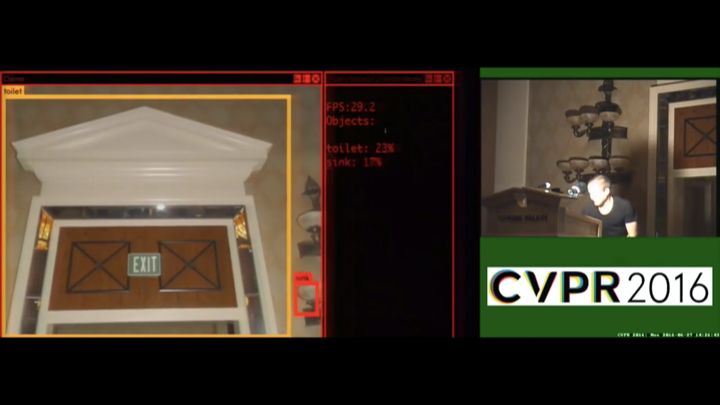

#### YOLO v2 의 목적

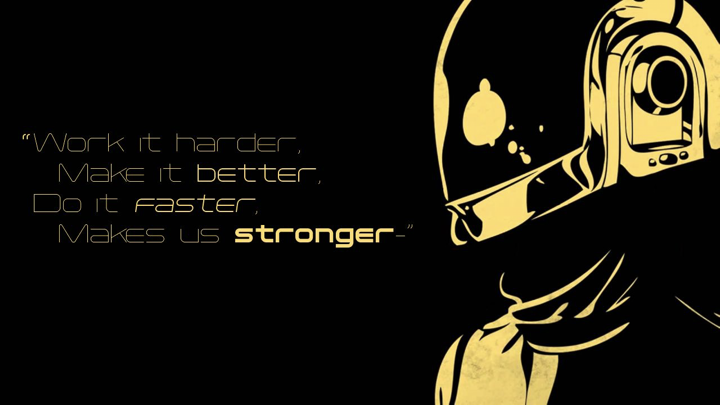

YOLO의 목적은 아래와 같습니다.

1. Make it better
2. Do it faster
3. Makes us stronger

간단히 요약하자면 recall을 올리고 localization을 잘해보자! 이다.

##### Make it better

Better는 정확도를 올리기 위한 방법이다. YOLO v2에서는 이전 모델에서 낮은 성능으로 보였던 localization과 recall을 높이면서도 여전히 모델을 단순하게 만들고 속도도 빠르게 하려고 하였다.

이를 위해 Batch Normalization, High Resolution Classifier, Convolutional with Anchor boxes, Dimension Clusters, Direct location prediction, Fine-Grained Features, Multi-Scale Training 등의 방법을 사용하였다. 각 방법을 사용했을 때의 결과는 아래의 표로 정리되어 있습니다.

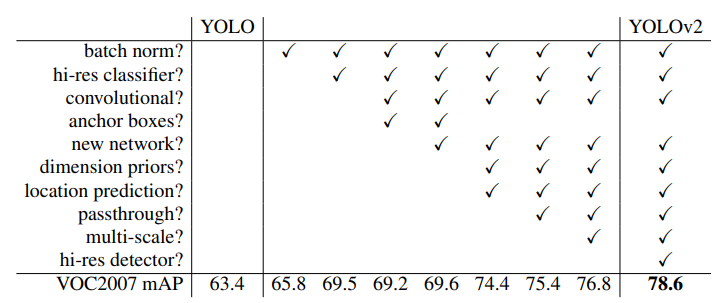

정확도를 높이기 위해 사용했던 각각의 방법을 간단히 정리하면 아래와 같다.

**Batch Normalization**

모든 conv 레이어에 batch normalization을 사용하였고, dropout은 제거하였다. 이로써 mAP에서 2% 이상의 성능 개선을 하였다. 

**High Resolution Classifier**

YOLO v1에서 ImageNet의 224 x 224 이미지를 학습하고, detection에서 448 x 448 이미지를 사용했던 것과 달리 YOLO v2에서는 처음부터 448 x 448의 해상도로 학습하였다. 이로써 mAP에서 4% 정도의 성능 개선을 이루었다.

**Convolutional With Anchor Boxes**



bounding box를 예측하기 위해 YOLO v1의 Fully connected 레이어를 제거한 후 Fully Convolutional Network를 사용하였고, anchor box들을 사용해 bounding box를 예측하였다.

또한 1개의 중앙점을 갖는 13 x 13(홀수 x 홀수)의 출력 feature map을 만들도록 입력 이미지의 크기를 448 x 448에서 416 x 416로 줄였다. 이는 대부분의 객체가 이미지의 중앙에 있는데, 중앙에 위치한 객체의 경우는 중앙점이 하나일 경우에 더 잘 예측할 것이라는 예상 때문이었다.

따라서 YOLO v2는 13 * 13 * 5개의 bounding box를 예측한다.

그 결과 mAP는 69.5에서 69.2로 떨어지지만 recall은 81%에서 88%로 증가하였다.

**Dimension Cluster**

Fast R-CNN에서는 anchor box의 크기와 비율을 사전에 정해주고, 학습을 통해 세부 조정을 했다.

그러나, YOLO v2는 k-means clustering을 적용해 최적의 anchor box를 결정하였다.

하지만 유클리드 거리를 사용하는 일반적인 k-means clustering과 달리 IoU 개념을 distance metric으로 사용해 더 좋은 anchor box를 얻을 수 있었다. 그 이유는 ground truth box와 유사한, 즉 ioU가 높은 anchor box를 찾기 위해서였다.

클러스터링 개수를 늘리면 정확도가 높아지지만 속도가 느려지므로 YOLO v2는 최종적으로 5개의 anchor box를 사용했다.

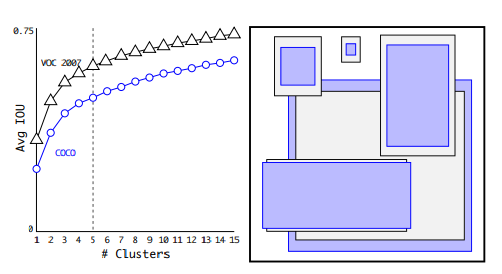

**Direct location prediction**

YOLO v2는 결정한 anchor box에 따라서 하나의 셀에서 5차원의 벡터로 이루어진 bounding box를 아래와 같은 방식으로 조정하여 예측했다. 학습 초반에 random initialization으로 인한 학습의 불안정을 예방하기 위해 bounding box가 grid cell을 벗어나지 않도록 제약을 둔거다. 주의할 점은 YOLO v1이 grid cell의 중앙점을 예측하였다면 YOLO v2은 최상단으로부터 얼마나 이동하였는지 예측한다는 것이다.

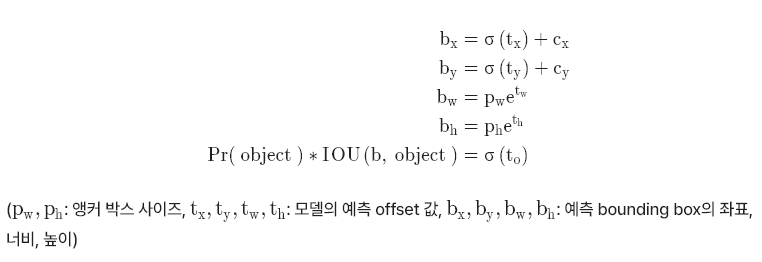

Dimension Cluster와 Direct location prediction를 사용해 약 5%의 성능 향상을 얻었다.

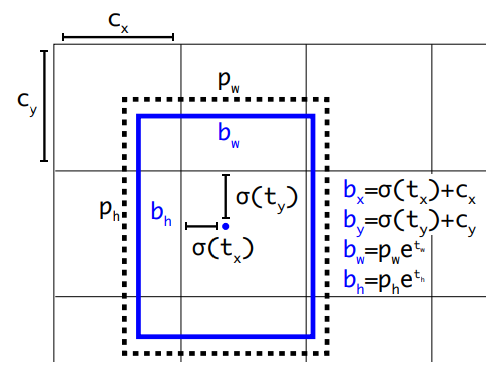

**Fine-Grained Features**

13 x 13의 feature map은 작은 물체 검출을 잘 하지 못한다는 단점이 있었기 때문에 YOLO v2는 passingthrough 레이어라는 것을 사용했다. passingthrough 레이어는 이전 레이어의 26 x 26 feature map과 13 x 13의 feature map을 concatenate한다. 이렇게 하는 이유는 26 x 26의 feature map에 Fine-Grained Features(고해상도 피처)가 담겨 있기 때문이다.

그러나 두 feature map의 크기가 다르기 때문에 26 x 26 x 512 feature map을 13 x 13 x 2048 feature map으로 변환한 후 concatenate하였다.

이로써 약 1%의 성능 향상을 보였다.

**Multi-Scale Training**

모델이 다양한 입력 사이즈에도 예측을 잘 할 수 있도록 매 10개의 batch마다 입력 이미지의 크기를 바꿔가면서 모델 학습을 하였다. 모델이 32 간격으로 downsample 되므로 입력 이미지는 32의 배수가 될 수 있다. 그래서 입력 이미지의 크기는 (320,352,...608) 중 하나가 사용된다.

##### Do it faster

faster는 detection 속도를 향상시키기 위한 방법이었다.

**Darknet-19**

YOLO v2에서는 Fully Connected 레이어를 제거하고 global average pooling을 하여 가중치 파라미터 수를 크게 줄였다. 이렇게 해서 만든 최종 모델은 Darknet-19이라고 불리는데, 19개의 convolutional 레이어와 5개의 maxpooling 레이어로 이루어져 있다.

DarkNet-19를 통과한 YOLO v2의 최종 출력은 13 x 13 x 125이다. 위에서 feature map이 13 x 13이라고 하였고, 5개의 bounding box를 예측하기 때문에 5 * (5 + 20)이므로 13 x 13 x 125이다. 이전 스텝에서 하나의 bounding box가 x,y,w,h confidence를 예측하고, 클래스의 개수가 20개였던 것이 기억이 나는가 ?

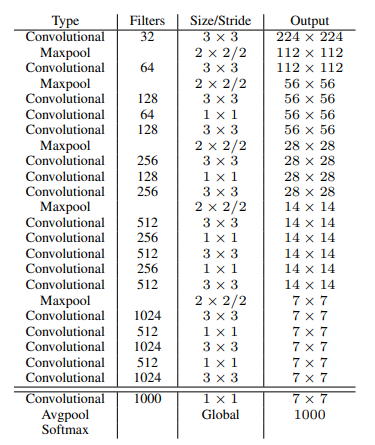

##### Makes us stronger

stronger는 더 많은 범위의 class를 예측하기 위한 방법이다. YOLO v1는 PASCAL VOC 데이터셋에서 제공되는 20개의 클래스를 기준으로 학습해서 20개의 클래스만 detection하였다. 그러나 YOLO v2에서는 9천개의 클래스에서 detection할 수 있도록 하고, 그 모델을 YOLO9000이라고 불렀다. 그래서인지 YOLO v2는 YOLO9000 : Better, Faster, Stronger이라는 논문 이름으로 발표되었다.

https://openaccess.thecvf.com/content_cvpr_2017/papers/Redmon_YOLO9000_Better_Faster_CVPR_2017_paper.pdf

간단히 설명하자면 9천개의 클래스에 대해 분류를 하기 위해 계층적으로 분류 작업(Hierachical Classification)을 수행하여 기존의 WordNet 기반의 데이터를 트리 구조인 WordTree를 생성하였다.

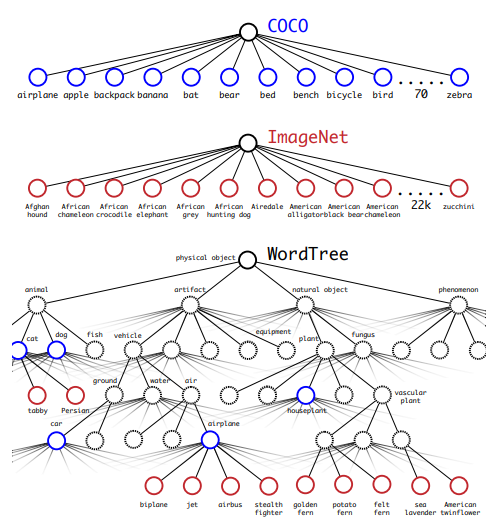

ImageNet + COCO 데이터셋 + ImageNet Detection을 합쳐 9천개의 클래스 라벨을 생성했다. 그 후 Detection과 Classification을 합쳐서 학습을 하는데, Detection 데이터셋과 Classification 데이터셋의 개수가 차이가 크기 때문에 oversampling하여 Detection과 Classification 비율을 4:1로 맞췄다. Detection 데이터셋은 classification과 bbox에 대한 loss를 역전파하였지만 Classification 데이터셋은 classfication loss만 역전파하여 학습하였다. 이로 인해 9천개의 클래스를 detection할 수 있었다.

#### YOLO v2 의 성능비교

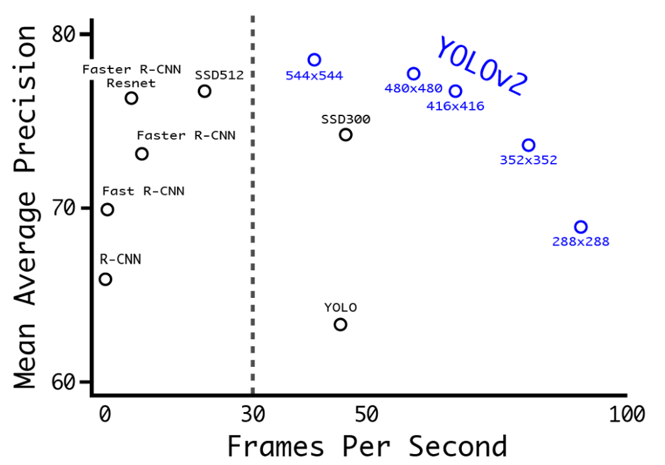

YOLO v2의 성능은 위의 그래프에서도 볼 수 있듯이 mAP가 상승하고 FPS도 개선되었다는 점을 알 수 있다.

그러나 여전히 mAP와 FPS간의 trade-off가 존재하였다.

YOLO v2 발표 당시 SSD, R-FCN 등이 이미 발표된 상황이었다. 특히 SSD와 YOLO는 같은 single stage 방법을 지향하고 있었기 때문에 경쟁 모델이 되었고, YOLO v2 입장에서는 SSD와의 성능 차이를 부각시키는 게 중요한 과제였다.

### YOLO (5) YOLO v3

#### RetinaNet의 도발


아래의 RetinaNet figure를 보시면 YOLO v2를 언급하면서 보통 figure에는 그려주지도 않는 신선함을 보여줍니다. "YOLO 이제 퇴물아니야?"라는 느낌을 풍기면서 말이죠. 😝

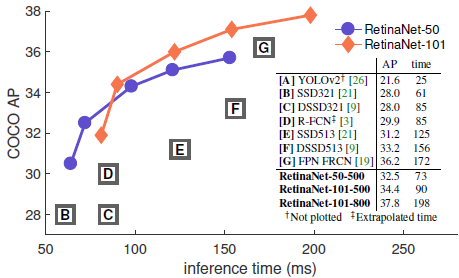

하지만 역시 CV의 힙스터 Redmon은 새로운 YOLO를 들고 RetinaNet과 정면 비교하였다.

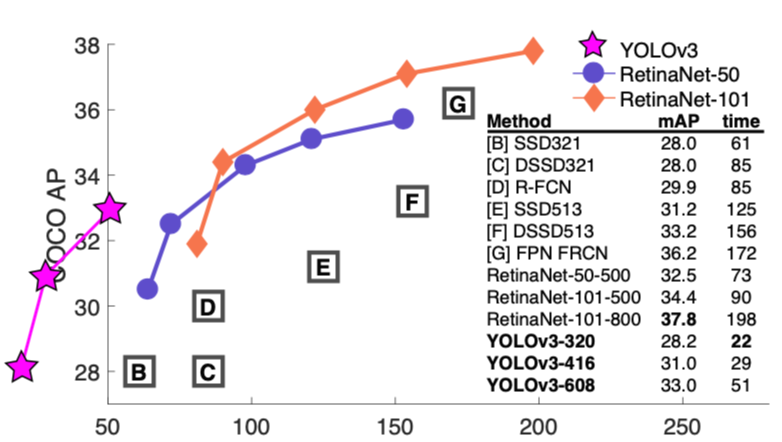

RetinaNet figure를 그대로 가지고 와서 YOLO v3 성능을 박아 넣었다.

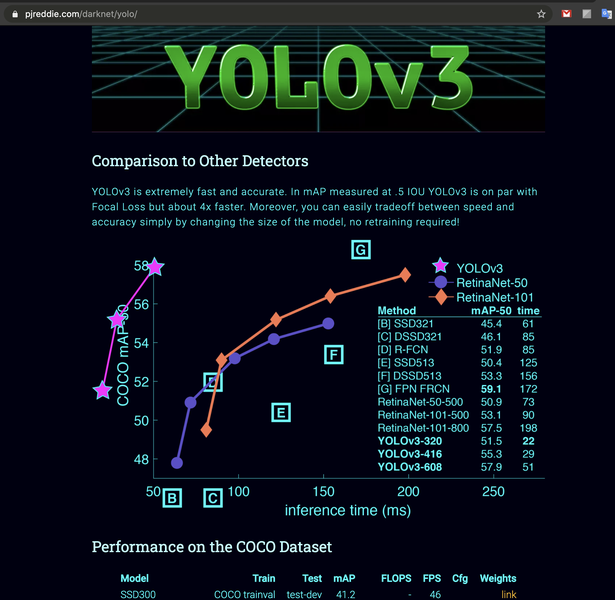

#### YOLO v3 원리

YOLO v3는 YOLO v2보다는 속도는 조금 느리지만 정확도를 개선한 모델이다. 특히 YOLO의 약점이었던 작은 물체를 detection할 때 성능을 개선하였다.

YOLO v3는  YOLOv3: An Incremental Improvement라는 이름의 논문에 소개되었다. 그러나 엄밀히 말하면 논문이라기보다 Tech Report인데, 이전의 YOLO 모델과의 차이점을 간략하게 소개한 보고서이다.

사실 YOLO v3는 YOLO v2에서 약간의 변화만 추가한 모델이다. 따라서 YOLO v3의 원리는 YOLO v2와의 차이점을 중심으로 보겠다.

**Bounding Box Prediction**

Bounding Box Prediction은 YOLO v2와는 거의 차이가 없다. 그러나 각각의 bounding box마다 objectness score, 즉 bounding box에 물체가 있는 지를 예측하는 점수를 logistic regression을 사용해 예측하였다. anchor box와 ground truth box의 IoU가 가장 높은 박스의 objectness score는 1로 두고 나머지는 무시하였다. 또한 Faster R-CNN 등의 다른 모델과 달리 각각의 ground truth에 대해 1개의 boundung box만 가지게 된다는 차이가 있었다.

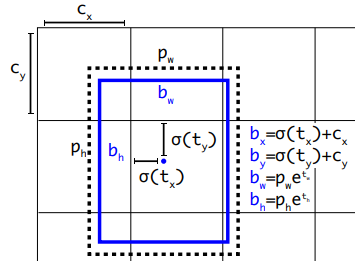

**Class prediction**

YOLO v3는 하나의 이미지에 다양한 label을 붙일 수 있는 multilabel classification를 하였다. 예를 들어 여성의 이미지에 person과 woman이라는 두가지의 label을 붙일 수 있는 것을 의미한다. 이를 위해 여러 개 중 하나만 찾는 softmax classifier가 아닌 해당 label이 맞는지 아닌지를 판단하는 logistic classifier를 사용하였고, binary cross entropy를 사용해 loss를 계산하였다.

**Predictions Across Scales**

YOLO v3은 3개의 scale로 bounding box를 예측하였고, 각 scale당 3개의 bouding box를 예측하였다. 따라서 총 9개의 bounding box가 나오게 되며, 텐서는 N x N x [3 * (4 + 1 + 80)]이다. 여기서 3은 anchor box의 수이고, 4는 boundig box의 좌표, 너비, 높이이며, 1은 objectness score, 그리고 80의 클래스의 수이다.

또한 feature map을 2배씩 upsampling함(13,26,52)으로써 더 의미 있는 semantic information을 얻고, 이전 feature map과 concatennate하여 보다 fine-grained한 정보를 얻을 수 있었다고 한다.

**DarkNet-53**

성능을 높이기 위해 YOLO v3은 53개의 레이어를 사용하였다. YOLO v2의 아키택처였던 DarkNet-19에 residual network를 넣어 레이어를 53개까지 쌓을 수 있었다.

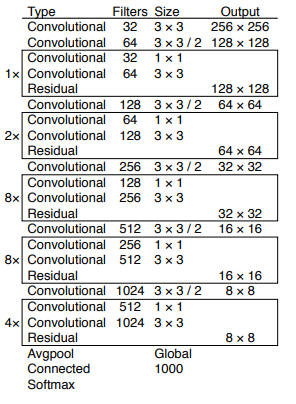

DarkNet-53은 DarkNet-19보다 정확도가 높았고, ResNet-101이나 ResNet152과 성능이 비슷하지만 연산면에서 효율적이었다.

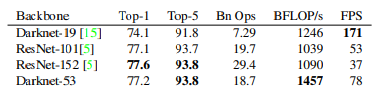

전체 모델 구조는 아래의 이미지로 나타낼 수 있다. 입력 이미지를 DarkNet-53에 통과시켜서 downsampling하면서 feature map을 추출한다. 이 feature map을 토대로 detection을 하고, upsampling 후 다시 detection하고 다시 upsampling을 한 후에 detection하게 된다. 즉 3개의 scale된 bounding box를 이용한 detection을 함으로써 여러 개의 label에 대해서도 classification을 할 수 있었다.

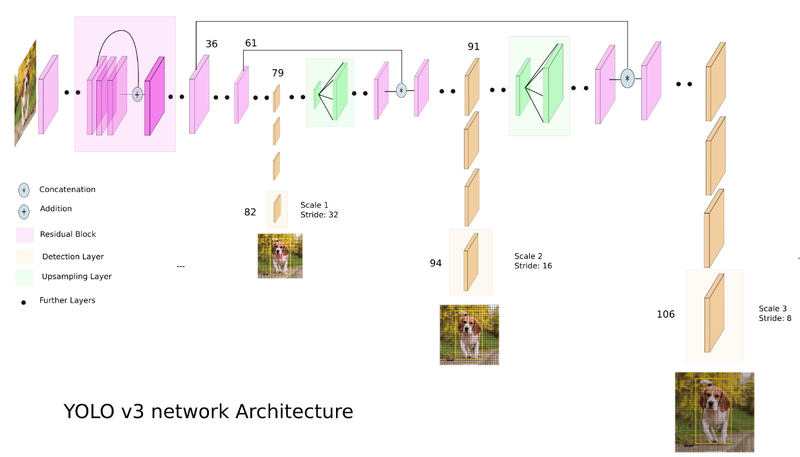

### YOLO v3 그 이후

Redmon은 Computer Vision 연구가 자신의 목적과는 다르게 군사적으로 사용되고 있는 것에 큰 회의감을 느끼고 CV 연구를 그만두겠다고 선언했다. YOLO 등 DarkNet 프로젝트는 Alexey Bochkovskiy가 메인테이너로 이어 받게 되었따. 그 후에도 다양한 사람들에 의해 YOLO를 이용한 다양한 모델이 나왔다.

#### YOLO v4

Redmon이 빠진 후 Alexey Bochkovskiy가 2020년 4월에 YOLO v4를 발표하였다. 아래 그림과 같이 YOLO v3보다 AP와 FPS가 각각 10%, 12% 증가된 것을 볼 수 있다.

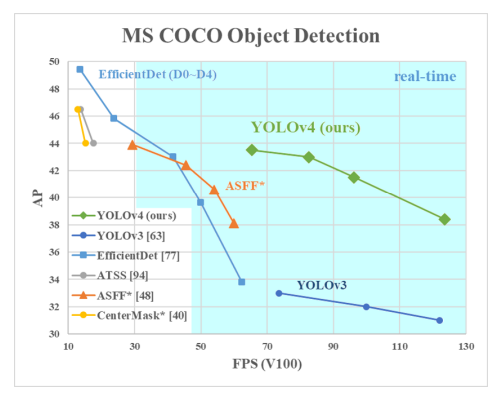

YOLO v4를 간단히 설명하자면 YOLO v3에 다양한 기법을 사용해 하나의 GPU(1080 Ti 또는 2080 Ti)로 object detection을 실시간으로 할 수 있도록 만든 모델이다. 논문에서도 다양한 기법을 소개하고, 그 기법들을 실행한 결과를 정리하여 YOLO v4라는 모델을 만들어 냈다. 따라서 YOLO v4를 아래와 같이 나타낼 수 있다. 백본으로는 CSPDarknet53을 사용하였고, Neck(feature map 정제 및 재구성)으로는 SPP와 PAN, Head(object classification, localization)에서는 YOLO v3를 사용한 거다.

**YOLO v4 = YOLO v3+ CSPDarknet53 + SPP + PAN(Path Aggregation Network) + BoF(Bag of Freebies) + Bos(Bag of Specials)**

참고로 Bag of Freebies는 inference cost의 변함 없이 성능을 향상시키는 방법으로 전처리 또는 학습 단계에서 사용된다. Data Augmentation, Regularization, Loss Function 등이 이 기법에 속한다. Bag of Specials는 inference cost가 조금 상승하면서 성능을 향상시키는 방법으로, inference 단계나 후처리 단계에서 사용된다. Enhance Receptive field, Feature integration, Activation function, Attention Module, Normalization, Post Processing 등이 해당된다.

각각의 자세한 내용은 논문 YOLOv4: Optimal Speed and Accuracy of Object Detection을 참고해 보세요.

https://arxiv.org/pdf/2004.10934.pdf

#### YOLO v5

YOLO v5는 2020년 6월에 YOLO v3을 PyTorch로 구현한 Glenn Jocher에 의해 발표되었다. 하지만 YOLO v5는 처음으로 논문과 함께 발표되지 않은 최초의 모델이자, DarkNet이 아닌 PyTorch로의 구현이므로 기존의 YOLO 모델과 많이 다르다는 이유로, YOLO v5라는 이름에 대해 논란이 있었떤 모델이다. YOLO v5 코드는 Ultralytics LLC라는 회사의 깃허브에 공개되어 있다.

https://github.com/ultralytics/yolov5

YOLO v4와 성능은 비슷하지만 용량이 훨씬 작고 속도도 빠르다.

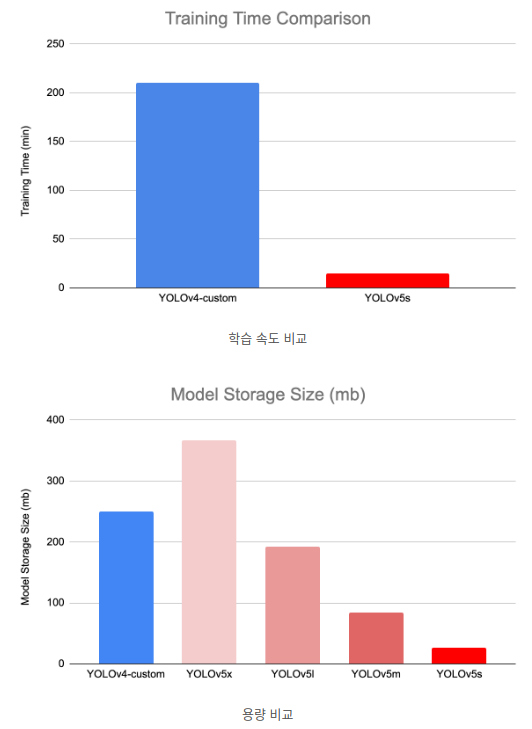

YOLO v5는 OLOv5s, YOLOv5m, YOLOv5l, YOLOv5x라는 이름의 4가지 버전이 있다. 각각 small, medium, large, xlarge로, 백본이나 head는 동일하지만 모델 깊이와 레이어의 채널 수가 다르다. YOLOv5s는 (0.33, 0.50), YOLOv5m은 (0.67, 0.75), YOLOv5l은 (1.0, 1.0), YOLOv5x (1.33, 1.25)의 비율이며, 그에 따른 성능은 아래와 같이 s가 가장 빠르고, 정확도는 x가 가장 높다.

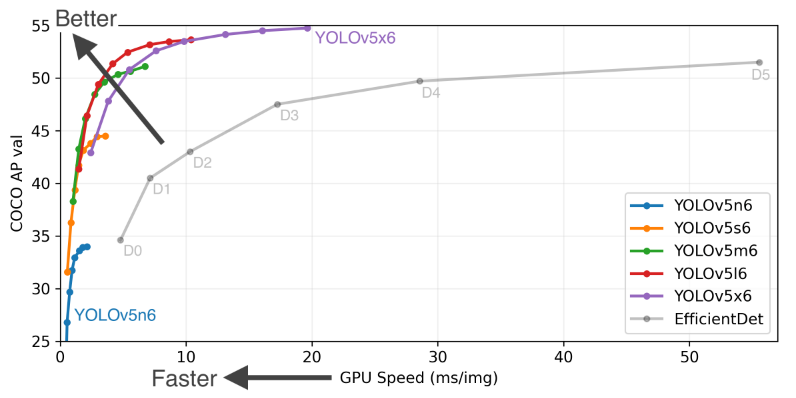

YOLO v5는 YOLO v4의 백본과 유사하게 CSP-Darknet을 사용하고, YOLO v3과 동일하게 3가지 scale에서 bounding box를 각각 3개씩 찾는다. 

https://ropiens.tistory.com/44

#### PPYOLO

PPYOLO는 2020년 8월에 바이두에서 발표된 모델로, PP라는 것은 바이두에서 만든 오픈 소스 딥러닝 전용 프레임워크 PaddlePaddle의 약자이다. 즉 PPYOLO는 PaddlePaddle을 이용해 구현한 YOLO 계열의 모델이다. PPYOLO를 소개한 논문  PP-YOLO: An Effective and Efficient Implementation of Object Detector은 YOLO v4와 비슷하게, 좋다고 알려진 다양한 기법을 사용해 YOLO v3의 성능을 올린 과정을 소개한 논문이다.

https://arxiv.org/pdf/2007.12099.pdf

그러나 YOLO v4와 달리 백본 네트워크, Data augmentation, NAS 등은 사용하지 않았는데, 그 이유는 일반적인 방법을 사용해 YOLO v3의 성능을 올리기 위해서라고 한다. 만약 YOLO v4에서 사용한 기법을 사용하면 PPYOLO의 성능은 더 좋아질 것이라고 한다.

PPYOLO의 기본 구조는 YOLO v3와 거의 동일하다. 다만 다른 것은 백본을 DarkNet-53 대신 ResNet50-vd를 사용한 것과 Inject Points 3가지가 추가로 적용된다는 것이다.

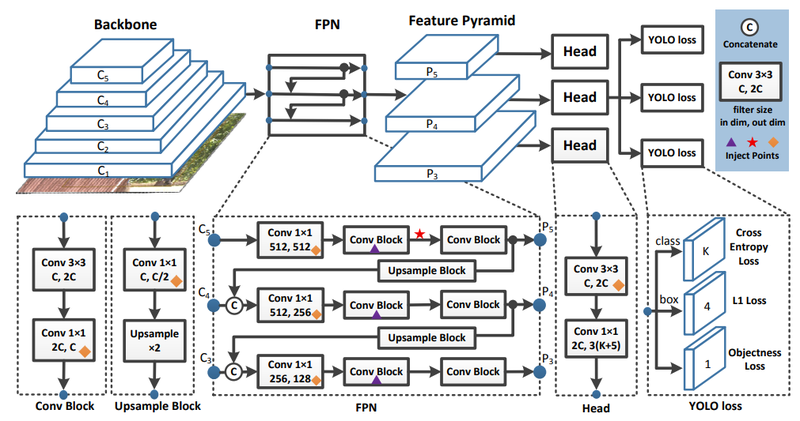

PPYOLO에서는 YOLO v4와 비슷하게 Larger Batch Size, EMA, DropBlock Regularization, SPP 등 다양한 방법을 사용해 실험을 했다. 

PPYOLO의 성능은 YOLO v4보다 정확도와 속도가 높았다.

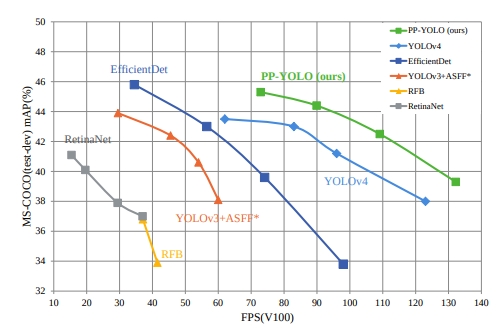

#### Scaled YOLO v4

2020년 11월, YOLO v4에 scaling 기술을 적용한 Scaled YOLO v4가 공개되었다. Scaled YOLO v4는 다양한 디바이스 환경에서 실시간으로 객체를 탐색하면서도 높은 정확도를 갖출 수 있도록 모델에 scaling 기술을 YOLO v4에 적용하였다.  YOLO v4 -> YOLOv4-CSP-> Scaled YOLO v4의 순서로 모델을 만들었다고 한다. YOLO v4에 CSP를 적용한 이유는 기존 모델에 CSPNet을 적용하면 FLOPs(FLoating point Operations Per Second)을 현저히 줄일 수 있기 때문이었다. 또한 모델의 scaling의 상한과 하한을 정해 YOLOv4-large와 YOLOv4-tiny model을 만들었습니다.

아래의 그림은 YOLO v4-large의 아키텍처이다. 먼저 CSP를 완전히 적용한 YOLOv4-P5를 디자인한 후, 이를 스케일링 업하여 -P6, -P7 버전을 만들었다고 한다.

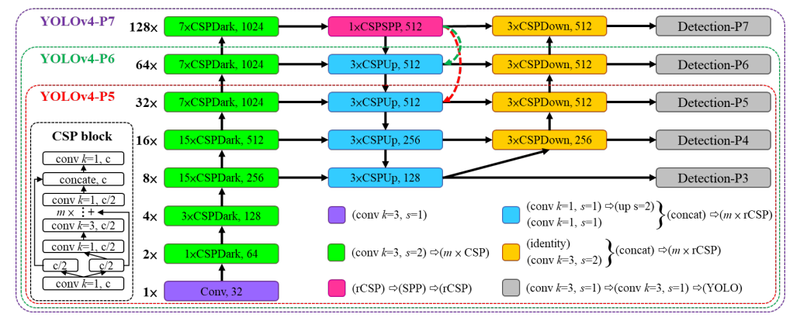

Scaled YOLO v4는 발표 당시 기존의 object detection 분야에서 가장 좋은 성능을 가지고 있었다. Scaled YOLO v4에 대한 자세한 내용은 논문 Scaled-YOLOv4: Scaling Cross Stage Partial Network을 참고하자.

https://arxiv.org/pdf/2011.08036.pdf



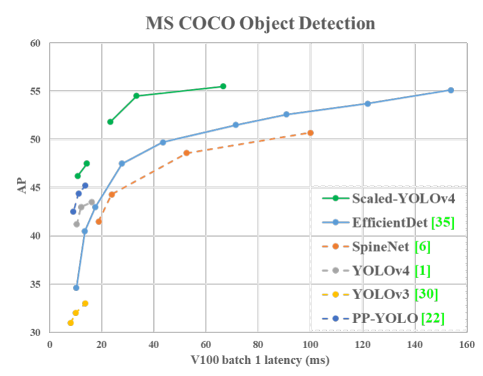

#### PPYOLO v2


2021년 4월 PPYOLO의 업그레이드된 모델인 PPYOLO v2가 공개되었다. PPYOLO v2의 성능과 정확도는 당시의 다른 모델보다 좋았다는 것을 아래의 그림을 통해 알 수 있다.

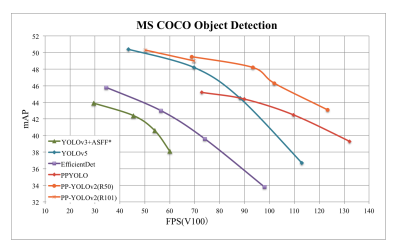

PPYOLO v2는 PPYOLO의 성능을 향상시키기 위해 mish 활성화 함수와 Path Aggregating Network 등 다양한 실험을 했다고 한다. 자세한 내용은 논문 PP-YOLOv2: A Practical Object Detector을 참고하자.

https://arxiv.org/pdf/2104.10419.pdf



#### YOLOR

2021년 5월에 YOLOR이 논문 You Only Learn One Representation: Unified Network for Multiple Tasks에서 소개되었다.  YOLOR은 Scaled YOLO v4에서 파생된 모델로 같은 저자에 의해 쓰여졌다.

https://arxiv.org/pdf/2105.04206.pdf

YOLOR은 사람이 학습할 때 명시적 지식(explicit knowlege)과 암묵적 지식(implicit knowlege)를 사용한다는 것에서 착안하여 만들어진 모델이다. 참고로 명시적 지식은 말과 글로 표현할 수 있는 지식이고, 암묵적 지식은 문자나 언어가 아닌 경험이나 학습에 의해 체득된 지식이다. YOLOR은 사람의 일반적인 학습 과정을 딥러닝에 적용하여 general representation을 생성하는 통합된 네트워크를 구성하였다. 이로써 YOLOR은 멀티 테스크를 잘 수행할 수 있었다.

YOLOR의 아키택처는 단순한데, YOLO v4 CSP 모델의 feature alignment, prediction refinement, multitask에 암묵적 지식을 아래와 같이 더해주는 것이다. 암묵적 지식의 형태나 어떻게 모델에 적용되는지는 논문을 참고해라.

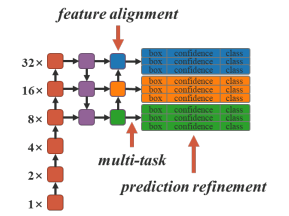

#### YOLOX

2021년 8월에 나온 YOLOX: Exceeding YOLO Series in 2021는 Anchor-Free Detector, Advanced Label Assignment Strategy, End-to-end Detector 등의 최신 연구를 적용하여 YOLO v3 SPP의 성능을 개선하였다.

아래 그림은 베이스라인으로 사용한 YOLO v3과의 차이를나타내고 있다. YOLOX는 특히 Decoupled Head, Strong Data Augmentation, Anchor-Free, Multi-positives를 통해 성능 향상을 꾀하고 있따. Decoupled Head는 prediction 하고자 하는 값에 따라 Head를 나누어 학습 속도를 빠르게 했고, Detector를 End-to-End 방식으로 만들 수 있었다.

Anchor-Free는 ground truth box와 생성된 bounding box 안의 cell이 겹쳐 있으면 positive, 아니면 negative로 지정하여 detection을 수행한다. 이로 인해 연산량을 낮추고, 일반화를 시킬 수 있으며 class imbalance 문제도 해결하고 정확도를 높이 수 있었다고 한다.

그러나 Anchor-Free 방식만으로는 Anchor 메커니즘의 정확도를 따라잡을 수 없었기 때문에 Multi-positives를 사용하였다. Multi-positives는 각 객체의 중심과 주변에 해당하는 cell을 positive로 할당하여 예측을 하는 방법으로, 낮은 loss를 가진 k개의 cell만 학습에 참여시키는 simOTA과 함께 사용하여 정확도를 향상시켰다. YOLOX에 대해 더 자세한 내용은 논문을 참고해라.

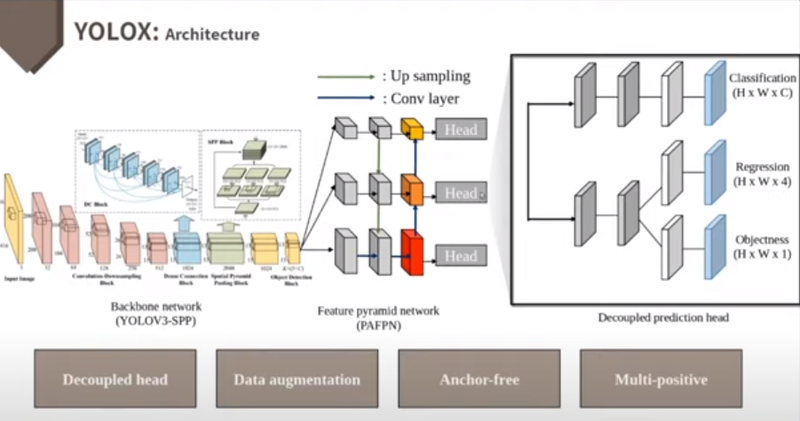

#### YOLOS

NLP 분야에서 큰 영향을 끼치고 있는 Transformer는 CV에서도 점차 영향력을 키우고 있따. 이런 흐름에 맞춰 2021년 10월 You Only Look at One Sequence: Rethinking Transformer in Vision through Object Detection라는 논문에서 YOLOS라는 모델이 소개되었다. 즉 YOLOS는 Transformer Encoder와 NLP Heads만을 사용해 2D object detection을 수행한 모델이다.

https://arxiv.org/pdf/2106.00666.pdf

YOLOS의 성능은 최근에 나온 다르 YOLO 계열의 모델과 비교했을 때 아주 좋지는 않다. YOLO v3이나 RetinaNet와 비슷한 정도의 성능을 보이고 있따. 하지만 Transformer를 object detection에 적용했다는 점에서 주목해볼만 하다.

아래 그림은 YOLOS의 모델 구조이다. 간단히 설명하자면 YOLOS는 Transformer와 DETR의 Bipartite Loss를 합친 모델이다. 자세한 내용은 논문을 참고해라.

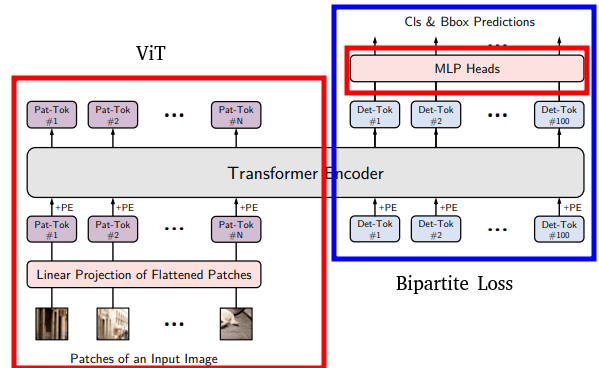